In [78]:
# import os
# os.listdir('../input')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
pd.set_option('display.max_columns',10000); pd.set_option('display.max_rows', 50); np.set_printoptions(threshold=90000)

import sys, os
sys.path.append('../../src/') #モジュールが入っているディレクトリのパスを指定

# import eda
# import config
import maprepro as mpre
import maprepro2 as mpre2



In [79]:
path='../../input/'
# a = pd.read_csv(f'{path}air_reserve.csv',)
asi = pd.read_csv(f'{path}air_store_info.csv',)
avd = pd.read_csv(f'{path}air_visit_data.csv',)
di = pd.read_csv(f'{path}date_info.csv',)
# a = pd.read_csv(f'{path}hpg_reserve.csv',)
# a = pd.read_csv(f'{path}hpg_store_info.csv',)
sa = pd.read_csv(f'{path}sample_submission.csv',)
# a = pd.read_csv(f'{path}store_id_relation.csv',)


In [80]:
'''
- 店ごとに日付ごとの平均を出すと同時にnanを作って0で補完

'''
avd.index = pd.to_datetime(avd['visit_date'])
# # 店ごとに特定の日に何人来たか
avd = avd.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').mean()).reset_index()
# avd.query("air_store_id == 'air_00a91d42b08b08d9'" and "visit_date > '2016-07-01'" )
# filtered_df=df.query("Joined_date >= '2019-06-1' and Joined_date <='2020-02-05'")
avd['visit_date'] = avd['visit_date'].dt.strftime('%Y-%m-%d')
avd['was_nil'] = avd['visitors'].isnull()
avd['visitors'].fillna(0, inplace=True)

avd.head(1)
# avd.shape

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False


In [81]:
# ラグ特徴量作成
date_info = pd.read_csv(f'{path}/date_info.csv')
date_info.rename(columns={'calendar_date': 'visit_date','holiday_flg': 'is_holiday'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head(1)
# date_info.shift()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0


In [82]:
'''
外れ値を適正値の中の最大値に置換
'''
def find_outliers(series):
    # 条件式なのでTrue,falseが返る
    return (series - series.mean()) > 2.4 * series.std()

def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series


stores = avd.groupby('air_store_id')
stores.apply(lambda g: find_outliers(g['visitors'])).values
avd['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values

avd['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
avd['visitors_capped_log1p'] = np.log1p(avd['visitors_capped'])

# avd.query("visit_date > '2016-01-01'" and "visit_date < '2016-01-05'").head(20)

In [83]:
sa['air_store_id'] = sa['id'].str.slice(0, 20)
sa['visit_date'] = sa['id'].str.slice(21)
sa['is_test'] = True
sa['visitors'] = np.nan
sa['test_number'] = range(len(sa))
# sa

In [84]:
'''air_visit+sample_submission+date_info+air_store_info'''

data = pd.concat((avd, sa.drop('id', axis='columns')))
data['is_test'].fillna(False, inplace=True)
data = pd.merge(data, date_info, how='left', left_on=['visit_date'], right_on=['visit_date'])
data = pd.merge(left=data, right=asi, on='air_store_id', how='left')


In [85]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.index = data['visit_date']

# astypeでtrue,false→1,0に変換できる
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day
data['month_of_year'] = data['visit_date'].dt.month # 0815
data['dow'] = data['visit_date'].dt.dayofweek
data = pd.get_dummies(data, columns=['air_genre_name'])
# data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])


In [86]:
print(data.shape)
tr = data.query("is_test == False")
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])

print(data.shape)


(328298, 34)
(328298, 39)


In [87]:
'''
air_store_id
visit_date
test_number

is_holiday
prev_day_is_holiday
next_day_is_holiday

air_area_name

latitude
longitude

is_weekend
day_of_month
day_of_week_??
air_genre_name_??

識別フラグ
is_test
was_nil

visitors
is_outlier
visitors_capped
visitors_capped_log1p
'''
data.head(2)

,air_store_id,visit_date,visitors,was_nil,is_outlier,visitors_capped,visitors_capped_log1p,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_area_name,latitude,longitude,is_weekend,day_of_month,month_of_year,dow,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,35.0,3.583519,False,NaN,Friday,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,1,7,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,33.953488,35.0,57.0,43
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,9.0,2.302585,False,NaN,Saturday,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,1,2,7,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,13.232558,9.0,99.0,43


In [88]:
# data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)]
test = data[data['is_test']].sort_values('test_number')

to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name','day_of_week']
        #    'visitors_capped_log1p']
# to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
#            'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
#            'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
#            'station_great_circle', 'visitors_capped_log1p']
train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')

# X_train = train.drop('visitors_log1p', axis='columns')
X_train = train.drop('visitors_capped_log1p', axis='columns')
X_test = test.drop('visitors_capped_log1p', axis='columns')
# X_test = test.drop('visitors_log1p', axis='columns')
# y_train = train['visitors_log1p']
y_train = train['visitors_capped_log1p']

In [89]:
import hashlib

class TunerCVCheckpointCallback(object):
    """Optuna の LightGBMTunerCV から学習済みモデルを取り出すためのコールバック"""

    def __init__(self):
        # オンメモリでモデルを記録しておく辞書
        self.cv_boosters = {}

    @staticmethod
    def params_to_hash(params):
        """パラメータを元に辞書のキーとなるハッシュを計算する"""
        # params_hash = hash((frozenset(params.items())))
        params_hash = hashlib.sha512(str(frozenset(params.items())).encode()).hexdigest()
        return params_hash

    def get_trained_model(self, params):
        """パラメータをキーとして学習済みモデルを取り出す"""
        params_hash = self.params_to_hash(params)
        return self.cv_boosters[params_hash]

    def __call__(self, env):
        """LightGBM の各ラウンドで呼ばれるコールバック"""
        # 学習に使うパラメータをハッシュ値に変換する
        params_hash = self.params_to_hash(env.params)
        # 初登場のパラメータならモデルへの参照を保持する
        if params_hash not in self.cv_boosters:
            self.cv_boosters[params_hash] = env.model
        # else:
        #     print(f'{params_hash}が衝突しました'*2)
        #     self.cv_boosters[params_hash] = env.model
    

In [90]:
from optuna.integration import lightgbm as lgb
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection


np.random.seed(0)

n_splits = 2

# val_scores = [0] * n_splits

sub = sa['id'].to_frame()
sub['visitors'] = 0

feature_importances = pd.DataFrame(index=X_train.columns)

# デモ用にデータセットを分割する
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    shuffle=True,
                                                    random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

folds = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=0)

# 学習済みモデルへの参照を保持するためのコールバック
checkpoint_cb = TunerCVCheckpointCallback()
callbacks = [
    checkpoint_cb,
]

lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
}

tuner_cv = lgb.LightGBMTunerCV(
    lgbm_params, lgb_train,
    # num_boost_round=3,
    # early_stopping_rounds=1,
    # verbose_eval=20,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=200,
    folds=folds,
    callbacks=callbacks,
)

tuner_cv.run()
# NOTE: 念のためハッシュの衝突に備えて Trial の数と学習済みモデルの数を比較しておく
assert len(checkpoint_cb.cv_boosters) == len(tuner_cv.study.trials)
# assert len(checkpoint_cb.cv_boosters) == len(tuner_cv.study.trials) - 1
    
# 最も良かったパラメータをキーにして学習済みモデルを取り出す
cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)
# Averaging でホールドアウト検証データを予測する
# y_pred_proba_list = cv_booster.predict(X_test,
#                                         num_iteration=cv_booster.best_iteration)
# y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
# y_pred = np.where(y_pred_proba_avg > 0.5, 1, 0)

# sub['visitors'] /= n_splits
# sub['visitors'] = np.expm1(sub['visitors'])

# val_mean = np.mean(val_scores)
# val_std = np.std(val_scores)

# print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))


[I 2021-08-15 18:42:45,321] A new study created in memory with name: no-name-30c90caf-54a0-4044-b37a-9ce87c05ba09


[200]	cv_agg's rmse: 0.497996 + 0.00107853
[400]	cv_agg's rmse: 0.497014 + 0.00109129


[I 2021-08-15 18:42:47,398] Trial 0 finished with value: 0.4969088333685169 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.4969088333685169.


[200]	cv_agg's rmse: 0.497754 + 0.00108942
[400]	cv_agg's rmse: 0.496747 + 0.00109779


[I 2021-08-15 18:42:49,317] Trial 1 finished with value: 0.4966328727006911 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.4966328727006911.


[200]	cv_agg's rmse: 0.498711 + 0.0010882
[400]	cv_agg's rmse: 0.49753 + 0.000781936


[I 2021-08-15 18:42:51,669] Trial 2 finished with value: 0.4974436743570204 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.4966328727006911.


[200]	cv_agg's rmse: 0.497706 + 0.00126056
[400]	cv_agg's rmse: 0.496682 + 0.00134531
[600]	cv_agg's rmse: 0.49651 + 0.00138086


[I 2021-08-15 18:42:54,220] Trial 3 finished with value: 0.4965091962764566 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.4965091962764566.


[200]	cv_agg's rmse: 0.497552 + 0.0011014


[I 2021-08-15 18:42:55,913] Trial 4 finished with value: 0.49695892768291416 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.4965091962764566.


[400]	cv_agg's rmse: 0.496995 + 0.00106471
[200]	cv_agg's rmse: 0.497387 + 0.000759409
[400]	cv_agg's rmse: 0.496838 + 0.000920214


[I 2021-08-15 18:42:58,043] Trial 5 finished with value: 0.4967503349994362 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 3 with value: 0.4965091962764566.


[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.496601 + 0.0013031


[I 2021-08-15 18:42:59,952] Trial 6 finished with value: 0.49644627788792606 and parameters: {'feature_fraction': 0.8}. Best is trial 6 with value: 0.49644627788792606.
feature_fraction, val_score: 0.496446: 100%|##########| 7/7 [00:14<00:00,  2.09s/it]


[200]	cv_agg's rmse: 0.497336 + 0.00110252
[400]	cv_agg's rmse: 0.496683 + 0.00107687


[I 2021-08-15 18:43:01,789] Trial 7 finished with value: 0.4966002752218937 and parameters: {'num_leaves': 33}. Best is trial 7 with value: 0.4966002752218937.
[I 2021-08-15 18:43:03,967] Trial 8 finished with value: 0.4974520787467309 and parameters: {'num_leaves': 194}. Best is trial 7 with value: 0.4966002752218937.


[200]	cv_agg's rmse: 0.499642 + 0.00108876
[400]	cv_agg's rmse: 0.498094 + 0.00106638
[600]	cv_agg's rmse: 0.497357 + 0.00100802
[800]	cv_agg's rmse: 0.497002 + 0.00105165


[I 2021-08-15 18:43:06,160] Trial 9 finished with value: 0.49693550767804395 and parameters: {'num_leaves': 13}. Best is trial 7 with value: 0.4966002752218937.
[I 2021-08-15 18:43:08,683] Trial 10 finished with value: 0.4972902518972955 and parameters: {'num_leaves': 201}. Best is trial 7 with value: 0.4966002752218937.
[I 2021-08-15 18:43:10,726] Trial 11 finished with value: 0.49655038863363476 and parameters: {'num_leaves': 128}. Best is trial 11 with value: 0.49655038863363476.


[200]	cv_agg's rmse: 0.497072 + 0.000878947


[I 2021-08-15 18:43:12,918] Trial 12 finished with value: 0.4972677653969243 and parameters: {'num_leaves': 196}. Best is trial 11 with value: 0.49655038863363476.


[200]	cv_agg's rmse: 0.49696 + 0.000962491


[I 2021-08-15 18:43:14,814] Trial 13 finished with value: 0.496913179848533 and parameters: {'num_leaves': 90}. Best is trial 11 with value: 0.49655038863363476.
[I 2021-08-15 18:43:17,368] Trial 14 finished with value: 0.49739802125982335 and parameters: {'num_leaves': 208}. Best is trial 11 with value: 0.49655038863363476.


[200]	cv_agg's rmse: 0.498925 + 0.00132394
[200]	cv_agg's rmse: 0.496671 + 0.000838588


[I 2021-08-15 18:43:19,094] Trial 15 finished with value: 0.4966111897965026 and parameters: {'num_leaves': 81}. Best is trial 11 with value: 0.49655038863363476.


[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.496601 + 0.0013031


[I 2021-08-15 18:43:20,961] Trial 16 finished with value: 0.49644627788792606 and parameters: {'num_leaves': 31}. Best is trial 16 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.496741 + 0.000963714


[I 2021-08-15 18:43:22,645] Trial 17 finished with value: 0.4966145354226844 and parameters: {'num_leaves': 48}. Best is trial 16 with value: 0.49644627788792606.
[I 2021-08-15 18:43:24,565] Trial 18 finished with value: 0.49689822203533507 and parameters: {'num_leaves': 129}. Best is trial 16 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497355 + 0.000967634
[200]	cv_agg's rmse: 0.497635 + 0.000951339


[I 2021-08-15 18:43:27,225] Trial 19 finished with value: 0.49693005136324686 and parameters: {'num_leaves': 144}. Best is trial 16 with value: 0.49644627788792606.
[I 2021-08-15 18:43:30,087] Trial 20 finished with value: 0.4977094922796381 and parameters: {'num_leaves': 250}. Best is trial 16 with value: 0.49644627788792606.
[I 2021-08-15 18:43:32,112] Trial 21 finished with value: 0.49692582055822065 and parameters: {'num_leaves': 121}. Best is trial 16 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497235 + 0.000962955
[200]	cv_agg's rmse: 0.496774 + 0.00105371


[I 2021-08-15 18:43:34,242] Trial 22 finished with value: 0.4967252850522953 and parameters: {'num_leaves': 69}. Best is trial 16 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497774 + 0.00111889


[I 2021-08-15 18:43:36,629] Trial 23 finished with value: 0.49700072765185144 and parameters: {'num_leaves': 151}. Best is trial 16 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.500675 + 0.000898678
[400]	cv_agg's rmse: 0.499058 + 0.00103629
[600]	cv_agg's rmse: 0.498167 + 0.000944844
[800]	cv_agg's rmse: 0.497684 + 0.000939934


[I 2021-08-15 18:43:38,648] Trial 24 finished with value: 0.49748728482650484 and parameters: {'num_leaves': 9}. Best is trial 16 with value: 0.49644627788792606.


[1000]	cv_agg's rmse: 0.497487 + 0.000868372
[200]	cv_agg's rmse: 0.496943 + 0.000977051


[I 2021-08-15 18:43:40,652] Trial 25 finished with value: 0.49682251817341716 and parameters: {'num_leaves': 112}. Best is trial 16 with value: 0.49644627788792606.
[I 2021-08-15 18:43:42,703] Trial 26 finished with value: 0.49705699601096665 and parameters: {'num_leaves': 170}. Best is trial 16 with value: 0.49644627788792606.
num_leaves, val_score: 0.496446: 100%|##########| 20/20 [00:42<00:00,  2.14s/it]


[200]	cv_agg's rmse: 0.499115 + 0.000952494


[I 2021-08-15 18:43:44,085] Trial 27 finished with value: 0.4989997035263167 and parameters: {'bagging_fraction': 0.4363848591885913, 'bagging_freq': 4}. Best is trial 27 with value: 0.4989997035263167.


[200]	cv_agg's rmse: 0.49756 + 0.000949938


[I 2021-08-15 18:43:45,938] Trial 28 finished with value: 0.49734202789141535 and parameters: {'bagging_fraction': 0.8287485376414567, 'bagging_freq': 3}. Best is trial 28 with value: 0.49734202789141535.


[200]	cv_agg's rmse: 0.497785 + 0.00112093


[I 2021-08-15 18:43:47,860] Trial 29 finished with value: 0.4972904712230477 and parameters: {'bagging_fraction': 0.6984680428733856, 'bagging_freq': 5}. Best is trial 29 with value: 0.4972904712230477.


[200]	cv_agg's rmse: 0.497906 + 0.00118816


[I 2021-08-15 18:43:49,536] Trial 30 finished with value: 0.4976301319486641 and parameters: {'bagging_fraction': 0.7074889823894033, 'bagging_freq': 3}. Best is trial 29 with value: 0.4972904712230477.


[200]	cv_agg's rmse: 0.497696 + 0.000907105
[400]	cv_agg's rmse: 0.497 + 0.00108623


[I 2021-08-15 18:43:51,682] Trial 31 finished with value: 0.4969517288979166 and parameters: {'bagging_fraction': 0.9039720111555601, 'bagging_freq': 7}. Best is trial 31 with value: 0.4969517288979166.


[200]	cv_agg's rmse: 0.498185 + 0.00047589


[I 2021-08-15 18:43:53,769] Trial 32 finished with value: 0.4980135436780856 and parameters: {'bagging_fraction': 0.5942566396816926, 'bagging_freq': 2}. Best is trial 31 with value: 0.4969517288979166.


[400]	cv_agg's rmse: 0.498145 + 0.000492718
[200]	cv_agg's rmse: 0.498395 + 0.00109785


[I 2021-08-15 18:43:55,242] Trial 33 finished with value: 0.49836630260541015 and parameters: {'bagging_fraction': 0.5263724853639833, 'bagging_freq': 4}. Best is trial 31 with value: 0.4969517288979166.


[200]	cv_agg's rmse: 0.497806 + 0.000944301


[I 2021-08-15 18:43:57,171] Trial 34 finished with value: 0.4972720417716212 and parameters: {'bagging_fraction': 0.7740533258798172, 'bagging_freq': 4}. Best is trial 31 with value: 0.4969517288979166.


[400]	cv_agg's rmse: 0.497385 + 0.00110595
[200]	cv_agg's rmse: 0.49764 + 0.00104598


[I 2021-08-15 18:43:59,210] Trial 35 finished with value: 0.4971797932112012 and parameters: {'bagging_fraction': 0.7900874171575722, 'bagging_freq': 2}. Best is trial 31 with value: 0.4969517288979166.


[400]	cv_agg's rmse: 0.497357 + 0.000913058
[200]	cv_agg's rmse: 0.498095 + 0.000844265


[I 2021-08-15 18:44:00,828] Trial 36 finished with value: 0.4979133867054192 and parameters: {'bagging_fraction': 0.5780811268290794, 'bagging_freq': 4}. Best is trial 31 with value: 0.4969517288979166.
bagging, val_score: 0.496446: 100%|##########| 10/10 [00:18<00:00,  1.81s/it]


[200]	cv_agg's rmse: 0.497387 + 0.000759409
[400]	cv_agg's rmse: 0.496838 + 0.000920214


[I 2021-08-15 18:44:02,715] Trial 37 finished with value: 0.4967503349994362 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.4967503349994362.


[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.496601 + 0.0013031


[I 2021-08-15 18:44:04,600] Trial 38 finished with value: 0.49644627788792606 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497465 + 0.00112652
[400]	cv_agg's rmse: 0.496717 + 0.00119417


[I 2021-08-15 18:44:06,687] Trial 39 finished with value: 0.49662603883232903 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497754 + 0.00108942
[400]	cv_agg's rmse: 0.496747 + 0.00109779


[I 2021-08-15 18:44:08,638] Trial 40 finished with value: 0.4966328727006911 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497438 + 0.00103007
[400]	cv_agg's rmse: 0.496706 + 0.00101475


[I 2021-08-15 18:44:10,521] Trial 41 finished with value: 0.49665273808783506 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 38 with value: 0.49644627788792606.


[200]	cv_agg's rmse: 0.497561 + 0.00113817
[400]	cv_agg's rmse: 0.496873 + 0.00120293


[I 2021-08-15 18:44:12,337] Trial 42 finished with value: 0.49683505892072277 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 0.49644627788792606.
feature_fraction_stage2, val_score: 0.496446: 100%|##########| 6/6 [00:11<00:00,  1.92s/it]


[200]	cv_agg's rmse: 0.497477 + 0.0011713
[400]	cv_agg's rmse: 0.496559 + 0.00118712


[I 2021-08-15 18:44:14,323] Trial 43 finished with value: 0.49642590098766015 and parameters: {'lambda_l1': 1.3775128853081506, 'lambda_l2': 0.0061616146325814075}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497559 + 0.00136123
[400]	cv_agg's rmse: 0.496589 + 0.00124198


[I 2021-08-15 18:44:16,448] Trial 44 finished with value: 0.4965168096602367 and parameters: {'lambda_l1': 0.004728939686219355, 'lambda_l2': 2.10570095503734e-05}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497541 + 0.00121172
[400]	cv_agg's rmse: 0.496744 + 0.00125261


[I 2021-08-15 18:44:18,587] Trial 45 finished with value: 0.4966998893939446 and parameters: {'lambda_l1': 0.0008016631864530417, 'lambda_l2': 0.00012126820808489371}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.49763 + 0.0010057
[400]	cv_agg's rmse: 0.496715 + 0.00102049


[I 2021-08-15 18:44:20,690] Trial 46 finished with value: 0.4966049159788491 and parameters: {'lambda_l1': 0.015579063624683679, 'lambda_l2': 4.794941405728353}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497608 + 0.00113478
[400]	cv_agg's rmse: 0.496776 + 0.00107555


[I 2021-08-15 18:44:22,730] Trial 47 finished with value: 0.49667861683677084 and parameters: {'lambda_l1': 0.14268981299753153, 'lambda_l2': 0.0019196681671992664}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497505 + 0.00112273
[400]	cv_agg's rmse: 0.496858 + 0.00117871


[I 2021-08-15 18:44:24,539] Trial 48 finished with value: 0.4967772216635067 and parameters: {'lambda_l1': 9.251987676153863e-08, 'lambda_l2': 0.035007653273897404}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497539 + 0.00100898
[400]	cv_agg's rmse: 0.496832 + 0.000889396


[I 2021-08-15 18:44:26,739] Trial 49 finished with value: 0.4965758164812111 and parameters: {'lambda_l1': 0.38122943416989624, 'lambda_l2': 3.905010499144499e-07}. Best is trial 43 with value: 0.49642590098766015.


[600]	cv_agg's rmse: 0.496669 + 0.00101396
[200]	cv_agg's rmse: 0.497409 + 0.0012763
[400]	cv_agg's rmse: 0.496654 + 0.00131305


[I 2021-08-15 18:44:28,591] Trial 50 finished with value: 0.4965394490490584 and parameters: {'lambda_l1': 0.07319383857093623, 'lambda_l2': 8.99209353671452e-07}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497662 + 0.000995324
[400]	cv_agg's rmse: 0.496967 + 0.00104544


[I 2021-08-15 18:44:30,897] Trial 51 finished with value: 0.49678765409271325 and parameters: {'lambda_l1': 0.03151288875968217, 'lambda_l2': 0.6510766792523066}. Best is trial 43 with value: 0.49642590098766015.


[600]	cv_agg's rmse: 0.49691 + 0.0012729
[200]	cv_agg's rmse: 0.497583 + 0.00115405
[400]	cv_agg's rmse: 0.496824 + 0.000915225


[I 2021-08-15 18:44:32,806] Trial 52 finished with value: 0.4967743784814448 and parameters: {'lambda_l1': 0.007520221039988095, 'lambda_l2': 5.671463629042955e-05}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497535 + 0.00125145
[400]	cv_agg's rmse: 0.496677 + 0.00105513


[I 2021-08-15 18:44:34,732] Trial 53 finished with value: 0.4966248057120486 and parameters: {'lambda_l1': 2.8969710300457014e-06, 'lambda_l2': 0.01675953447562349}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497965 + 0.000817704
[400]	cv_agg's rmse: 0.497268 + 0.000825891


[I 2021-08-15 18:44:37,094] Trial 54 finished with value: 0.4972310876630775 and parameters: {'lambda_l1': 8.102990291482044, 'lambda_l2': 1.0614735428731484e-08}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.496525 + 0.00121172


[I 2021-08-15 18:44:38,999] Trial 55 finished with value: 0.49645704299434396 and parameters: {'lambda_l1': 2.30642029169573e-05, 'lambda_l2': 1.7330267787718915e-05}. Best is trial 43 with value: 0.49642590098766015.


[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.496687 + 0.000983686


[I 2021-08-15 18:44:41,311] Trial 56 finished with value: 0.4964065240471137 and parameters: {'lambda_l1': 1.924005740134561e-05, 'lambda_l2': 0.0027467315647182185}. Best is trial 56 with value: 0.4964065240471137.


[600]	cv_agg's rmse: 0.496511 + 0.00105047
[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.496804 + 0.000994841


[I 2021-08-15 18:44:43,243] Trial 57 finished with value: 0.49666206818720027 and parameters: {'lambda_l1': 3.337076289724409e-05, 'lambda_l2': 0.0023615458113550748}. Best is trial 56 with value: 0.4964065240471137.


[200]	cv_agg's rmse: 0.497597 + 0.00124268
[400]	cv_agg's rmse: 0.49666 + 0.00111201


[I 2021-08-15 18:44:45,505] Trial 58 finished with value: 0.49657728671672857 and parameters: {'lambda_l1': 1.5829450363646306e-08, 'lambda_l2': 0.10031434500035634}. Best is trial 56 with value: 0.4964065240471137.


[200]	cv_agg's rmse: 0.497427 + 0.00120189
[400]	cv_agg's rmse: 0.49674 + 0.000930908
[600]	cv_agg's rmse: 0.496647 + 0.000914487


[I 2021-08-15 18:44:48,882] Trial 59 finished with value: 0.49656035911359653 and parameters: {'lambda_l1': 1.1024625610477837e-06, 'lambda_l2': 0.0017298689288722925}. Best is trial 56 with value: 0.4964065240471137.


[200]	cv_agg's rmse: 0.497414 + 0.000818903
[400]	cv_agg's rmse: 0.496587 + 0.0008518


[I 2021-08-15 18:44:51,311] Trial 60 finished with value: 0.4963801947112205 and parameters: {'lambda_l1': 2.3461562555323727, 'lambda_l2': 0.1814507979529618}. Best is trial 60 with value: 0.4963801947112205.


[600]	cv_agg's rmse: 0.496509 + 0.000789431
[200]	cv_agg's rmse: 0.497531 + 0.0011538
[400]	cv_agg's rmse: 0.496565 + 0.00112427
[600]	cv_agg's rmse: 0.496477 + 0.00112891


[I 2021-08-15 18:44:54,100] Trial 61 finished with value: 0.4964408357041675 and parameters: {'lambda_l1': 0.00016370959752664345, 'lambda_l2': 9.085582047877256}. Best is trial 60 with value: 0.4963801947112205.


[200]	cv_agg's rmse: 0.497507 + 0.000943663
[400]	cv_agg's rmse: 0.496762 + 0.00102672


[I 2021-08-15 18:44:56,446] Trial 62 finished with value: 0.49674659402191546 and parameters: {'lambda_l1': 8.839662311326187e-07, 'lambda_l2': 0.33115600249350124}. Best is trial 60 with value: 0.4963801947112205.
regularization_factors, val_score: 0.496380: 100%|##########| 20/20 [00:44<00:00,  2.21s/it]


[200]	cv_agg's rmse: 0.497376 + 0.00100983
[400]	cv_agg's rmse: 0.496611 + 0.00120883


[I 2021-08-15 18:44:59,054] Trial 63 finished with value: 0.496499763626315 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.496499763626315.


[200]	cv_agg's rmse: 0.497682 + 0.00102313
[400]	cv_agg's rmse: 0.496883 + 0.00104037


[I 2021-08-15 18:45:01,460] Trial 64 finished with value: 0.4968319488080116 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.496499763626315.


[200]	cv_agg's rmse: 0.497275 + 0.00109851
[400]	cv_agg's rmse: 0.496347 + 0.00112031


[I 2021-08-15 18:45:03,542] Trial 65 finished with value: 0.4962528724008626 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.4962528724008626.


[200]	cv_agg's rmse: 0.497685 + 0.00100632
[400]	cv_agg's rmse: 0.497159 + 0.000865549


[I 2021-08-15 18:45:05,722] Trial 66 finished with value: 0.49709216812147994 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.4962528724008626.


[200]	cv_agg's rmse: 0.497466 + 0.00104515
[400]	cv_agg's rmse: 0.496453 + 0.000917064


[I 2021-08-15 18:45:08,008] Trial 67 finished with value: 0.4962154412438128 and parameters: {'min_child_samples': 5}. Best is trial 67 with value: 0.4962154412438128.
min_data_in_leaf, val_score: 0.496215: 100%|##########| 5/5 [00:11<00:00,  2.31s/it]

[600]	cv_agg's rmse: 0.496291 + 0.000940722


AssertionError: 

In [92]:
best_params = tuner_cv.best_params
best_params

In [93]:
sub = sa['id'].to_frame()
sub['visitors'] = 0

X_train = train.drop('visitors_capped_log1p', axis='columns')
y_train = train['visitors_capped_log1p']
X_test = test.drop('visitors_capped_log1p', axis='columns')

model = lgbm.LGBMRegressor(**best_params)

model.fit(
    X_train,
    y_train,
    verbose=False
)

sub['visitors'] = model.predict(X_test)
sub['visitors'] = np.expm1(sub['visitors'])
sub


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.598665
1,air_00a91d42b08b08d9_2017-04-24,18.438579
2,air_00a91d42b08b08d9_2017-04-25,24.427006
3,air_00a91d42b08b08d9_2017-04-26,27.418166
4,air_00a91d42b08b08d9_2017-04-27,29.044828
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.497891
32015,air_fff68b929994bfbd_2017-05-28,3.159665
32016,air_fff68b929994bfbd_2017-05-29,3.684733
32017,air_fff68b929994bfbd_2017-05-30,4.361639


In [94]:
NOW = mpre2.mk_now()
NOW

'2021-08-15_18-46-11'

In [95]:
# missing_values_table(sub)
sub.to_csv(f'../../output/{NOW}.csv',index=False)
tmp = pd.read_csv(f'../../output/{NOW}.csv')
tmp

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.598665
1,air_00a91d42b08b08d9_2017-04-24,18.438579
2,air_00a91d42b08b08d9_2017-04-25,24.427006
3,air_00a91d42b08b08d9_2017-04-26,27.418166
4,air_00a91d42b08b08d9_2017-04-27,29.044828
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.497891
32015,air_fff68b929994bfbd_2017-05-28,3.159665
32016,air_fff68b929994bfbd_2017-05-29,3.684733
32017,air_fff68b929994bfbd_2017-05-30,4.361639


In [ ]:
aggregation = {'visitors' : 'median'}
vagg = v.groupby(['air_store_id','dow']).agg(aggregation).reset_index()
vagg

,air_store_id,dow,visitors
0,air_00a91d42b08b08d9,0,19.0
1,air_00a91d42b08b08d9,1,24.5
2,air_00a91d42b08b08d9,2,28.0
3,air_00a91d42b08b08d9,3,30.0
4,air_00a91d42b08b08d9,4,35.5
...,...,...,...
5736,air_fff68b929994bfbd,2,4.0
5737,air_fff68b929994bfbd,3,4.0
5738,air_fff68b929994bfbd,4,5.0
5739,air_fff68b929994bfbd,5,7.0


In [ ]:

# submitのヘッダー情報
missing_values_table(submit)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,341,1.1


# 検証コード

<AxesSubplot:ylabel='Frequency'>

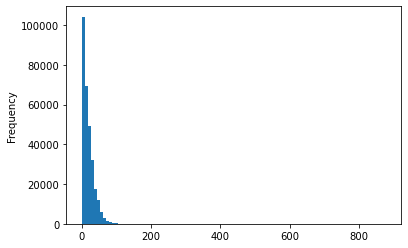

In [ ]:
# 売り上げが正規分布に従っているか検証、１店舗ごとにプロットすると正規分布に従うことがわかる
tmp = air_visit.query("air_store_id == 'air_00a91d42b08b08d9'")
# tmp['visitors'].plot.hist(bins=100)
# air_visit['visitors'].plot.hist(bins=100)

In [ ]:
cv.split(X_train, y_train)

In [ ]:
# hashlib.md5(b"1").digest()
import hashlib
# dat = frozenset(tuner_cv.best_params.items())
# SHA512のハッシュ値
# hs = hashlib.sha1()
hashlib.sha1(str(frozenset(tuner_cv.best_params.items())).encode().hexdigest())
# hs = hashlib.sha224(frozenset(tuner_cv.best_params.items()))
# hs = hashlib.sha224(dat.encode()).hexdigest()
# print(hs)
# dat


In [ ]:
# tuner_cv.best_score
# tuner_cv.best_params
# checkpoint_cb.cv_boosters[4115625917578661725]

len(checkpoint_cb.cv_boosters)
# len(tuner_cv.study.trials)
# checkpoint_cb.get_trained_model(tuner_cv.best_params)
# checkpoint_cb.cv_boosters.keys()
# # tuner_cv.best_params
# cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)


In [ ]:
'''GW中の移動平均を観察 見た感じ2016,2017のGWは祝日フラグを立ててもよさそう
is_holidayに代入するかと思ったけどすでにしてあった'''
# クエリが意図したとおりに動作しなかったのでクエリなしで
# tmp.query("visit_date2 > '2016-03-28'" and "visit_date2 < '2016-05-28'")

tmp = avd.groupby('visit_date').agg({'visitors': 'mean'})
tmp = tmp.query("index > '2016-03-28'" and "index < '2016-05-28'")
# print(tmp)
tmp['visit_date2'] = tmp.index
tmp['visit_date2'] = pd.to_datetime(tmp['visit_date2'])
tmp['visit_dateint'] = tmp['visit_date2'].astype(np.int64)
# 移動平均
window = 7
tmp["visitors_7"] = tmp["visitors"].rolling(window).mean()

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[12, 9]
fig1 = plt.figure(1)
################################
#1つ目のウィンドウ 1つ目のグラフ
################################
ax1 = fig1.add_subplot(211)
# plt.plot(tmp.visit_dateint, tmp.visitors_7)
plt.plot(tmp.visit_dateint, tmp.visitors)

plt.minorticks_on(); plt.grid(True, which='both') # whichがbothなので主目盛り副目盛り両方グリッド線を描画
p = plt.vlines([1461888000000000000], 10, 40, "blue", linestyles='dashed') # GW
p = plt.vlines([1462665600000000000], 10, 40, "blue", linestyles='dashed') # GW
p = plt.vlines([1462147200000000000], 10, 40, "red", linestyles='dashed') # GWだが5/2で平日
p = plt.vlines([1462492800000000000], 10, 40, "red", linestyles='dashed') # GWだが5/6で平日
# 2016
# 4月29日（金・祝）昭和の日
# 4月30日（土）
# 5月1日 （日）
# 5月2日 （月）平日
# 5月3日 （火・祝）憲法記念日
# 5月4日 （水・祝）みどりの日
# 5月5日 （木・祝）こどもの日
# 5月6日 （金）平日
# 5月7日（土）
# 5月8日（日）

In [ ]:
%matplotlib inline
import shap
shap.initjs()
X_test = shap.sample(X_test, 1000)
explainer = shap.TreeExplainer(model, data=X_test)
# Consider using shap.sample(data, 100) to create a smaller background data set.

# そして、TreeExplainer を使って、モデルがどのように推論するか解釈したいデータについて SHAP Value を計算しよう。
# この SHAP Value は、入力したのと同じ次元と要素数で得られる。 そして、値が大きいほど推論において影響が大きいと見なすことができる。
tr_x_shap_values = explainer.shap_values(X_test)
# つまり、行方向に見れば「特定の予測に、それぞれの特徴量がどれくらい寄与したか」と解釈できる。 
# 同様に、列方向に見れば「予測全体で、その特徴量がどれくらい寄与したか」と解釈できる。

# SHAP Value は自分で可視化しても良いけど、組み込みでいくつかグラフを描画する仕組みが用意されている。 ここからは、それらを使い分けなどと共に見ていこう。
# Summary Plot
# はじめに、Summary Plot から。 このグラフは、デフォルトでは特徴量ごとに SHAP Value を一軸の散布図として描画する。

shap.summary_plot(shap_values=tr_x_shap_values,
                  features=X_test,
                  feature_names=X_test.columns)
